# Running a model for split datasets

## Running same model on subsets of a single dataset

This section is based on [Chapter 25](https://r4ds.had.co.nz/many-models.html) of Garrett Grolemund's and Hadley Wickham's excellent book, [R for Data science](https://r4ds.had.co.nz/).

We will be using packages `tidyverse`, `broom`, `modelr` and `gapminder`. `gapminder` is a sample dataset from [Gapminder Foundation](https://www.gapminder.org/).

In [1]:
library(tidyverse)
if (!file.exists('rlibs')) {
    dir.create('rlibs')
}
if (!file.exists('rlibs/broom')) {
    install.packages('broom', repos="http://cran.r-project.org", lib='rlibs')
}
if (!file.exists('rlibs/gapminder')) {
    install.packages('gapminder', repos="http://cran.r-project.org", lib='rlibs')
}
library(broom, lib.loc='rlibs')
library(gapminder, lib.loc='rlibs')
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap




`gapminder` dataset contains yearly data of population, life expectancy and GDP on a country by country level.

In [2]:
head(gapminder)

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Afghanistan,Asia,1952,28.801,8425333,779.4453
Afghanistan,Asia,1957,30.332,9240934,820.8530
Afghanistan,Asia,1962,31.997,10267083,853.1007
Afghanistan,Asia,1967,34.020,11537966,836.1971
Afghanistan,Asia,1972,36.088,13079460,739.9811
Afghanistan,Asia,1977,38.438,14880372,786.1134


If we plot life expectancy vs time, we can see that for most countries this relationship seems almost linear.

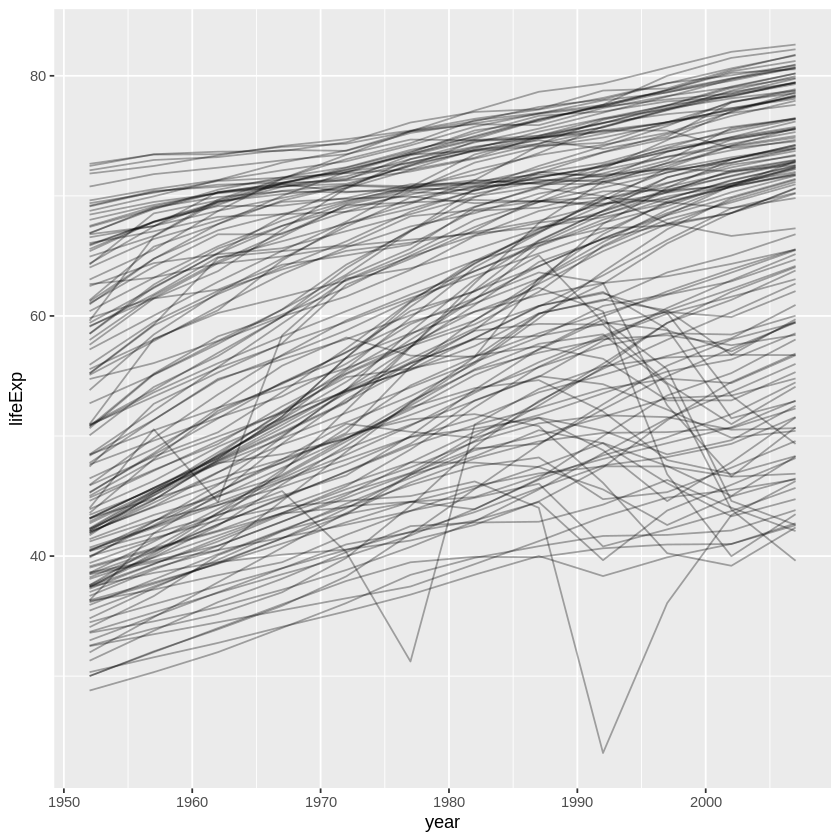

In [3]:
gapminder %>% 
  ggplot(aes(year, lifeExp, group = country)) +
    geom_line(alpha = 1/3)

Let's try this approach with one country e.g. New Zealand. Firstly, let's create a new tibble that has only New Zealand's data, Secondly, let's plot it.

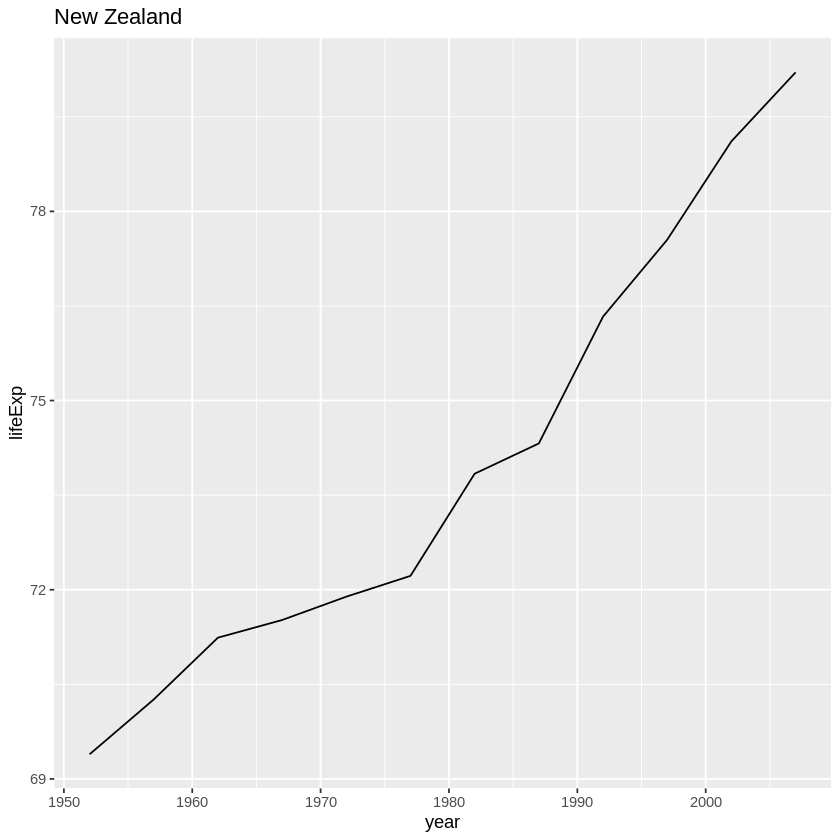

In [4]:
nz <- filter(gapminder, country == "New Zealand")
nz %>% 
  ggplot(aes(year, lifeExp)) + 
  geom_line() + 
  ggtitle("New Zealand")

Let's fit a linear model here.

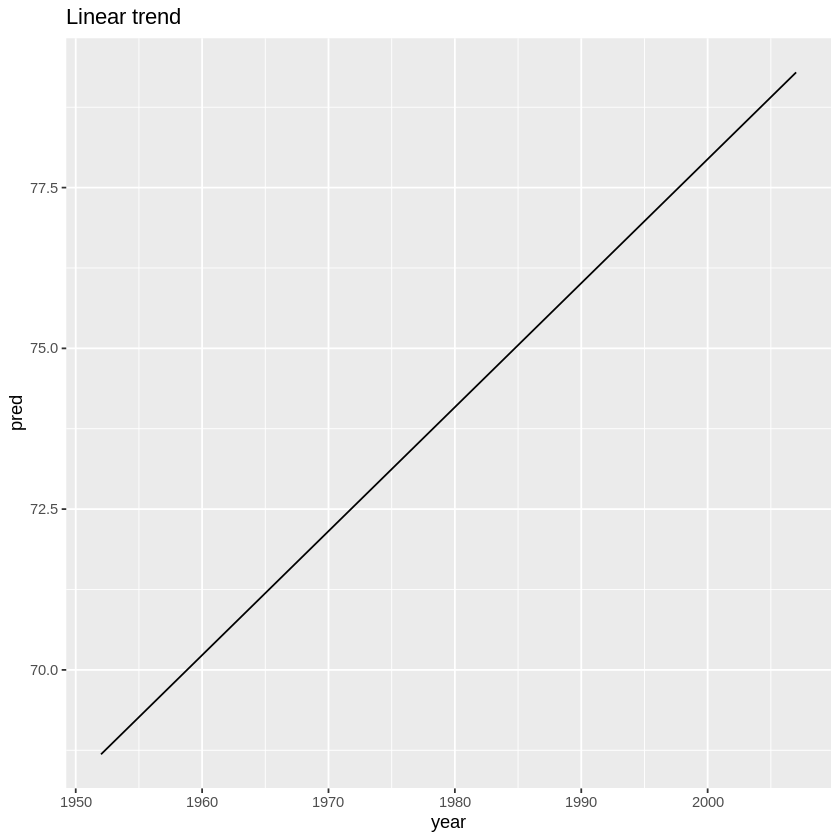

In [5]:
nz_model <- lm(lifeExp ~ year, data = nz)
nz %>% 
  add_predictions(nz_model) %>%
  ggplot(aes(year, pred)) + 
  geom_line() + 
  ggtitle("Linear trend")

To see how well this matches our original data, let's add residuals (the difference between fit and data) to the dataset with `add_residuals` [[add_residuals]](https://modelr.tidyverse.org/reference/add_residuals.html).

Let's plot this.

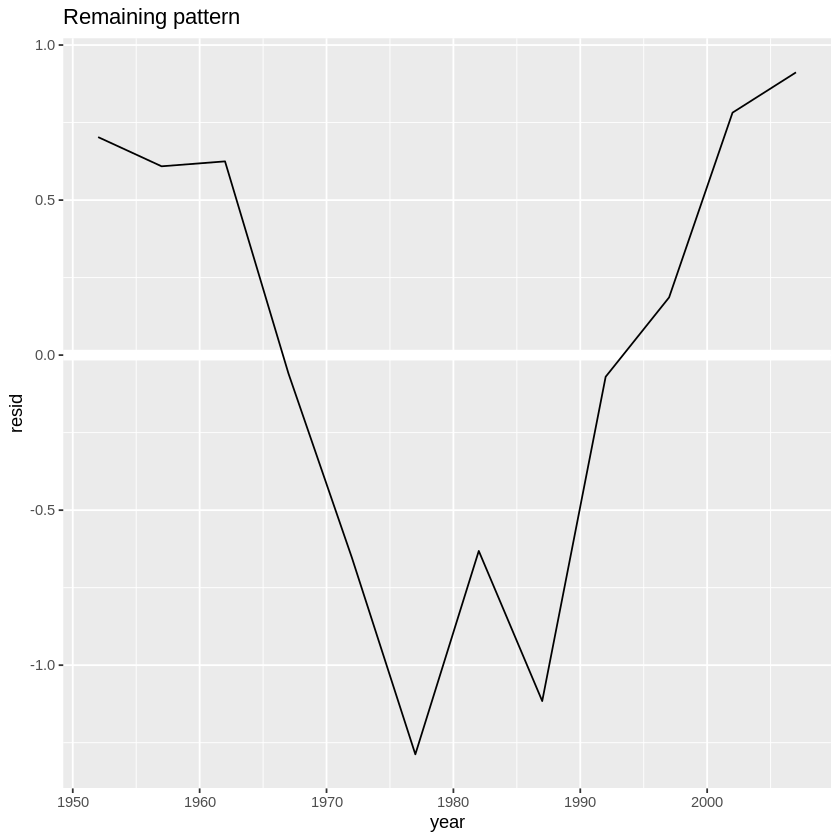

In [6]:
nz %>% 
  add_residuals(nz_model) %>% 
  ggplot(aes(year, resid)) + 
  geom_hline(yintercept = 0, colour = "white", size = 3) + 
  geom_line() + 
  ggtitle("Remaining pattern")

Not a perfect fit, but not bad either.

When doing the same for all countries, we'll first want to group the data per country and continent.

After that we can use the `nest`-function, to take all data that belongs to said groups into a sub-tibble ([[nest]](http://tidyr.tidyverse.org/reference/nest.html)).

In [7]:
by_country <- gapminder %>%
    group_by(country, continent) %>%
    nest()

print(by_country)

# A tibble: 142 x 3
   country     continent data             
   <fct>       <fct>     <list>           
 1 Afghanistan Asia      <tibble [12 × 4]>
 2 Albania     Europe    <tibble [12 × 4]>
 3 Algeria     Africa    <tibble [12 × 4]>
 4 Angola      Africa    <tibble [12 × 4]>
 5 Argentina   Americas  <tibble [12 × 4]>
 6 Australia   Oceania   <tibble [12 × 4]>
 7 Austria     Europe    <tibble [12 × 4]>
 8 Bahrain     Asia      <tibble [12 × 4]>
 9 Bangladesh  Asia      <tibble [12 × 4]>
10 Belgium     Europe    <tibble [12 × 4]>
# … with 132 more rows


Now you see that the `data`-variable is of type `list` and for each country we have the data that belongs to said country in its own tibble.

Thus we have split the dataset based on the grouping.

Now we can use `function` to create a generic linear model that we can use for each country.

In [8]:
country_model <- function(data) lm(lifeExp ~ year, data = data)

Notice that the data that goes into the model is a free parameter that is not yet defined. When running this function, `lm` assumes that the data contains columns `lifeExp` and `year`.

To run this model on each dataset in `data`-column, we can use the `map`-function.

`map` takes a `list` and a `function` and it will apply said `function` for each entry in that `list`. As its output it will return a new `list` with a same number of elements as the original `list`.

By using the `mutate`-function, we can put the resulting `list` into a new column in our tibble.

In [9]:
by_country <- by_country %>%
    mutate(
        model=map(data,country_model)
    )
print(by_country)

# A tibble: 142 x 4
   country     continent data              model 
   <fct>       <fct>     <list>            <list>
 1 Afghanistan Asia      <tibble [12 × 4]> <lm>  
 2 Albania     Europe    <tibble [12 × 4]> <lm>  
 3 Algeria     Africa    <tibble [12 × 4]> <lm>  
 4 Angola      Africa    <tibble [12 × 4]> <lm>  
 5 Argentina   Americas  <tibble [12 × 4]> <lm>  
 6 Australia   Oceania   <tibble [12 × 4]> <lm>  
 7 Austria     Europe    <tibble [12 × 4]> <lm>  
 8 Bahrain     Asia      <tibble [12 × 4]> <lm>  
 9 Bangladesh  Asia      <tibble [12 × 4]> <lm>  
10 Belgium     Europe    <tibble [12 × 4]> <lm>  
# … with 132 more rows


Let's say we want to see how well our models we fitted. For this we'll need to generate the residuals with `add_residuals` [[add_residuals]](https://modelr.tidyverse.org/reference/add_residuals.html).

Add residuals takes two arguments: `data` and a `model`. Thus we'll need to iterate over `data1` and `model1`, `data2` and `model2`, ...

For this we can use the `map2`-function [[map2]](https://purrr.tidyverse.org/reference/map2.html).

As its arguments it takes two lists `x` and `y` and a function `f`. As its output it will return `f(x_i,y_i)` for each element of the lists.

In [10]:
by_country <- by_country %>%
    mutate(
        residuals=map2(data, model, add_residuals)
    )

print(by_country)

# A tibble: 142 x 5
   country     continent data              model  residuals        
   <fct>       <fct>     <list>            <list> <list>           
 1 Afghanistan Asia      <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 2 Albania     Europe    <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 3 Algeria     Africa    <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 4 Angola      Africa    <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 5 Argentina   Americas  <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 6 Australia   Oceania   <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 7 Austria     Europe    <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 8 Bahrain     Asia      <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
 9 Bangladesh  Asia      <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
10 Belgium     Europe    <tibble [12 × 4]> <lm>   <tibble [12 × 5]>
# … with 132 more rows


Now we have the residuals in column `residuals`. To obtain the actual values from the `residuals`-column, we'll have to use `unnest` to reverse the nesting procedure [[unnest]](https://tidyr.tidyverse.org/reference/unnest.html).

In [11]:
residuals <- unnest(by_country, residuals)
head(residuals)

country,continent,year,lifeExp,pop,gdpPercap,resid
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>,<dbl>
Afghanistan,Asia,1952,28.801,8425333,779.4453,-1.10629487
Afghanistan,Asia,1957,30.332,9240934,820.8530,-0.95193823
Afghanistan,Asia,1962,31.997,10267083,853.1007,-0.66358159
Afghanistan,Asia,1967,34.020,11537966,836.1971,-0.01722494
Afghanistan,Asia,1972,36.088,13079460,739.9811,0.67413170
Afghanistan,Asia,1977,38.438,14880372,786.1134,1.64748834


Let's plot the residuals.

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



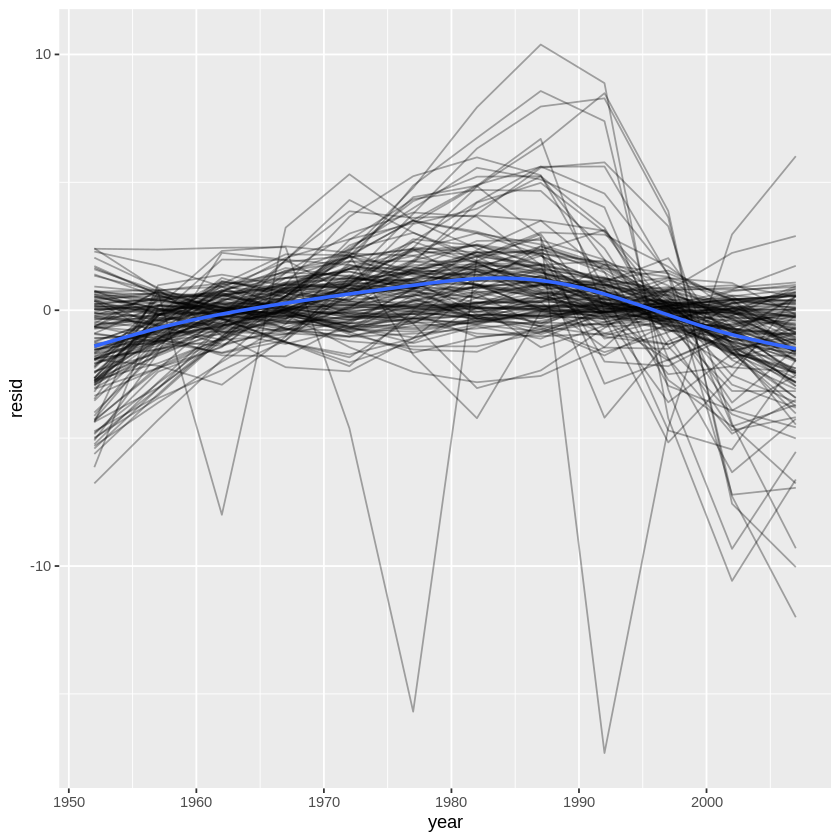

In [12]:
residuals %>% 
  ggplot(aes(year, resid)) +
    geom_line(aes(group = country), alpha = 1 / 3) + 
    geom_smooth(se = FALSE)

Looks ok for the most part. Some countries have quite big residuals.

Let's focus on finding those.

In the previous section we used `tidy` from `broom`-package to obtain parameters for models.

This time, let's use `glance` to obtain statistics on how good the fit was [[glance]](https://broom.tidyverse.org/reference/glance.lm.html).

For example, when used on `nz_model`, we obtain these nice statistics.

In [13]:
glance(nz_model)

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.9535846,0.9489431,0.8043472,205.4459,5.407324e-08,2,-13.32064,32.64128,34.096,6.469743,10


Let's use `map` to do the same on a model-by-model basis.

In [14]:
by_country <- by_country %>%
    mutate(
        model_perf=map(model, glance)
    )

print(by_country)

# A tibble: 142 x 6
   country     continent data             model  residuals       model_perf     
   <fct>       <fct>     <list>           <list> <list>          <list>         
 1 Afghanistan Asia      <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 2 Albania     Europe    <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 3 Algeria     Africa    <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 4 Angola      Africa    <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 5 Argentina   Americas  <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 6 Australia   Oceania   <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 7 Austria     Europe    <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 8 Bahrain     Asia      <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
 9 Bangladesh  Asia      <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
10 Belgium     Europe    <tibble [12 × 4… <lm>   <tibble [12 × … <tibble [1 × 1…
# … with

Now let's `unnest` the data.

In [15]:
model_perf <- unnest(by_country, model_perf)
print(model_perf)

# A tibble: 142 x 16
   country continent data  model residuals r.squared adj.r.squared sigma
   <fct>   <fct>     <lis> <lis> <list>        <dbl>         <dbl> <dbl>
 1 Afghan… Asia      <tib… <lm>  <tibble …     0.948         0.942 1.22 
 2 Albania Europe    <tib… <lm>  <tibble …     0.911         0.902 1.98 
 3 Algeria Africa    <tib… <lm>  <tibble …     0.985         0.984 1.32 
 4 Angola  Africa    <tib… <lm>  <tibble …     0.888         0.877 1.41 
 5 Argent… Americas  <tib… <lm>  <tibble …     0.996         0.995 0.292
 6 Austra… Oceania   <tib… <lm>  <tibble …     0.980         0.978 0.621
 7 Austria Europe    <tib… <lm>  <tibble …     0.992         0.991 0.407
 8 Bahrain Asia      <tib… <lm>  <tibble …     0.967         0.963 1.64 
 9 Bangla… Asia      <tib… <lm>  <tibble …     0.989         0.988 0.977
10 Belgium Europe    <tib… <lm>  <tibble …     0.995         0.994 0.293
# … with 132 more rows, and 8 more variables: statistic <dbl>, p.value <dbl>,
#   df <int>, logLik <dbl

This left the columns with `list`-datatype in the `model_perf`-tibble. Let's forcibly drop them with `.drop=TRUE` during unnesting.

In [16]:
model_perf <- unnest(by_country, model_perf, .drop=TRUE)
head(model_perf)

country,continent,r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Afghanistan,Asia,0.9477123,0.9424835,1.2227880,181.24941,9.835213e-08,2,-18.346935,42.693870,44.148590,14.9521045,10
Albania,Europe,0.9105778,0.9016355,1.9830615,101.82901,1.462763e-06,2,-24.149036,54.298071,55.752791,39.3253302,10
Algeria,Africa,0.9851172,0.9836289,1.3230064,661.91709,1.808143e-10,2,-19.292214,44.584427,46.039147,17.5034589,10
Angola,Africa,0.8878146,0.8765961,1.4070091,79.13818,4.593498e-06,2,-20.030928,46.061857,47.516577,19.7967471,10
Argentina,Americas,0.9955681,0.9951249,0.2923072,2246.36635,4.215567e-13,2,-1.173933,8.347866,9.802586,0.8544349,10
Australia,Oceania,0.9796477,0.9776125,0.6206086,481.34586,8.667222e-10,2,-10.208677,26.417353,27.872073,3.8515501,10


Now we have the fit statistics in a nice tidy format. Let's find the countries that bucked the trends by looking at the worst `r.squared` scores. 

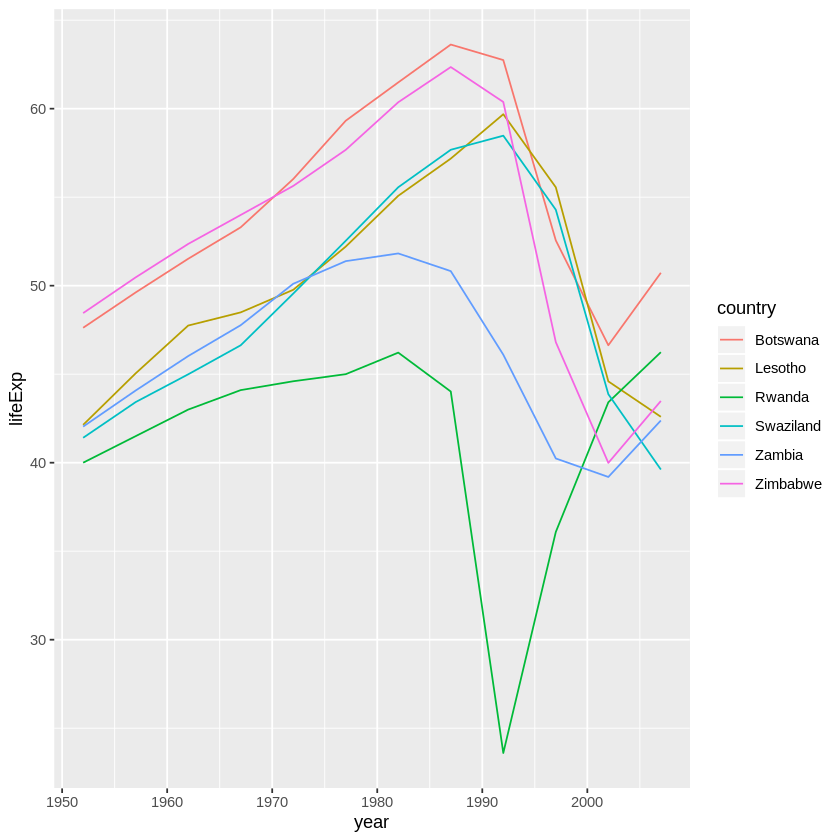

In [17]:
bad_fit <- filter(model_perf, r.squared < 0.25)

gapminder %>% 
  semi_join(bad_fit, by = "country") %>% 
  ggplot(aes(year, lifeExp, colour = country)) +
    geom_line()

## Exercise

Dataset `/m/jhnas/jupyter/shareddata/python-r-data-analysis/honey-production/honeyproduction.csv` contains data on honey production in the US.

1. Calculate the total amount of honey produced in the US for each year. Plot it.
2. For each state, fit a linear model totalprod ~ year. Plot original data and fitted lines.
3. Plot the slope coefficient of the linear fit.

In [18]:
honey <- read_csv("/m/jhnas/jupyter/shareddata/python-r-data-analysis/honey-production/honeyproduction.csv")

Parsed with column specification:
cols(
  state = col_character(),
  numcol = col_double(),
  yieldpercol = col_double(),
  totalprod = col_double(),
  stocks = col_double(),
  priceperlb = col_double(),
  prodvalue = col_double(),
  year = col_double()
)

